In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import learning_curve, GridSearchCV

#### adaboost regression用CART回归树作为弱分类器，树形结构不需要做归一化

In [2]:
with open("./zhengqi_train.txt") as fr:
    train_data = pd.read_csv(fr, sep="\t")
with open("./zhengqi_test.txt") as fr_test:
    test_data = pd.read_csv(fr_test, sep="\t")

In [3]:
# 查看是否有数据缺失
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 39 columns):
V0        2888 non-null float64
V1        2888 non-null float64
V2        2888 non-null float64
V3        2888 non-null float64
V4        2888 non-null float64
V5        2888 non-null float64
V6        2888 non-null float64
V7        2888 non-null float64
V8        2888 non-null float64
V9        2888 non-null float64
V10       2888 non-null float64
V11       2888 non-null float64
V12       2888 non-null float64
V13       2888 non-null float64
V14       2888 non-null float64
V15       2888 non-null float64
V16       2888 non-null float64
V17       2888 non-null float64
V18       2888 non-null float64
V19       2888 non-null float64
V20       2888 non-null float64
V21       2888 non-null float64
V22       2888 non-null float64
V23       2888 non-null float64
V24       2888 non-null float64
V25       2888 non-null float64
V26       2888 non-null float64
V27       2888 non-null float

In [4]:
train_data.describe()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
count,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,...,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000
mean,0.123048,0.056068,0.289720,-0.067790,0.012921,-0.558565,0.182892,0.116155,0.177856,-0.169452,...,0.097648,0.055477,0.127791,0.020806,0.007801,0.006715,0.197764,0.030658,-0.130330,0.126353
std,0.928031,0.941515,0.911236,0.970298,0.888377,0.517957,0.918054,0.955116,0.895444,0.953813,...,1.061200,0.901934,0.873028,0.902584,1.006995,1.003291,0.985675,0.970812,1.017196,0.983966
min,-4.335000,-5.122000,-3.420000,-3.956000,-4.742000,-2.182000,-4.576000,-5.048000,-4.692000,-12.891000,...,-2.912000,-4.507000,-5.859000,-4.053000,-4.627000,-4.789000,-5.695000,-2.608000,-3.630000,-3.044000
25%,-0.297000,-0.226250,-0.313000,-0.652250,-0.385000,-0.853000,-0.310000,-0.295000,-0.159000,-0.390000,...,-0.664000,-0.283000,-0.170250,-0.407250,-0.499000,-0.290000,-0.202500,-0.413000,-0.798250,-0.350250
50%,0.359000,0.272500,0.386000,-0.044500,0.110000,-0.466000,0.388000,0.344000,0.362000,0.042000,...,-0.023000,0.053500,0.299500,0.039000,-0.040000,0.160000,0.364000,0.137000,-0.185500,0.313000
75%,0.726000,0.599000,0.918250,0.624000,0.550250,-0.154000,0.831250,0.782250,0.726000,0.042000,...,0.745250,0.488000,0.635000,0.557000,0.462000,0.273000,0.602000,0.644250,0.495250,0.793250
max,2.121000,1.918000,2.828000,2.457000,2.689000,0.489000,1.895000,1.918000,2.245000,1.335000,...,4.580000,2.689000,2.013000,2.395000,5.465000,5.110000,2.324000,5.238000,3.000000,2.538000


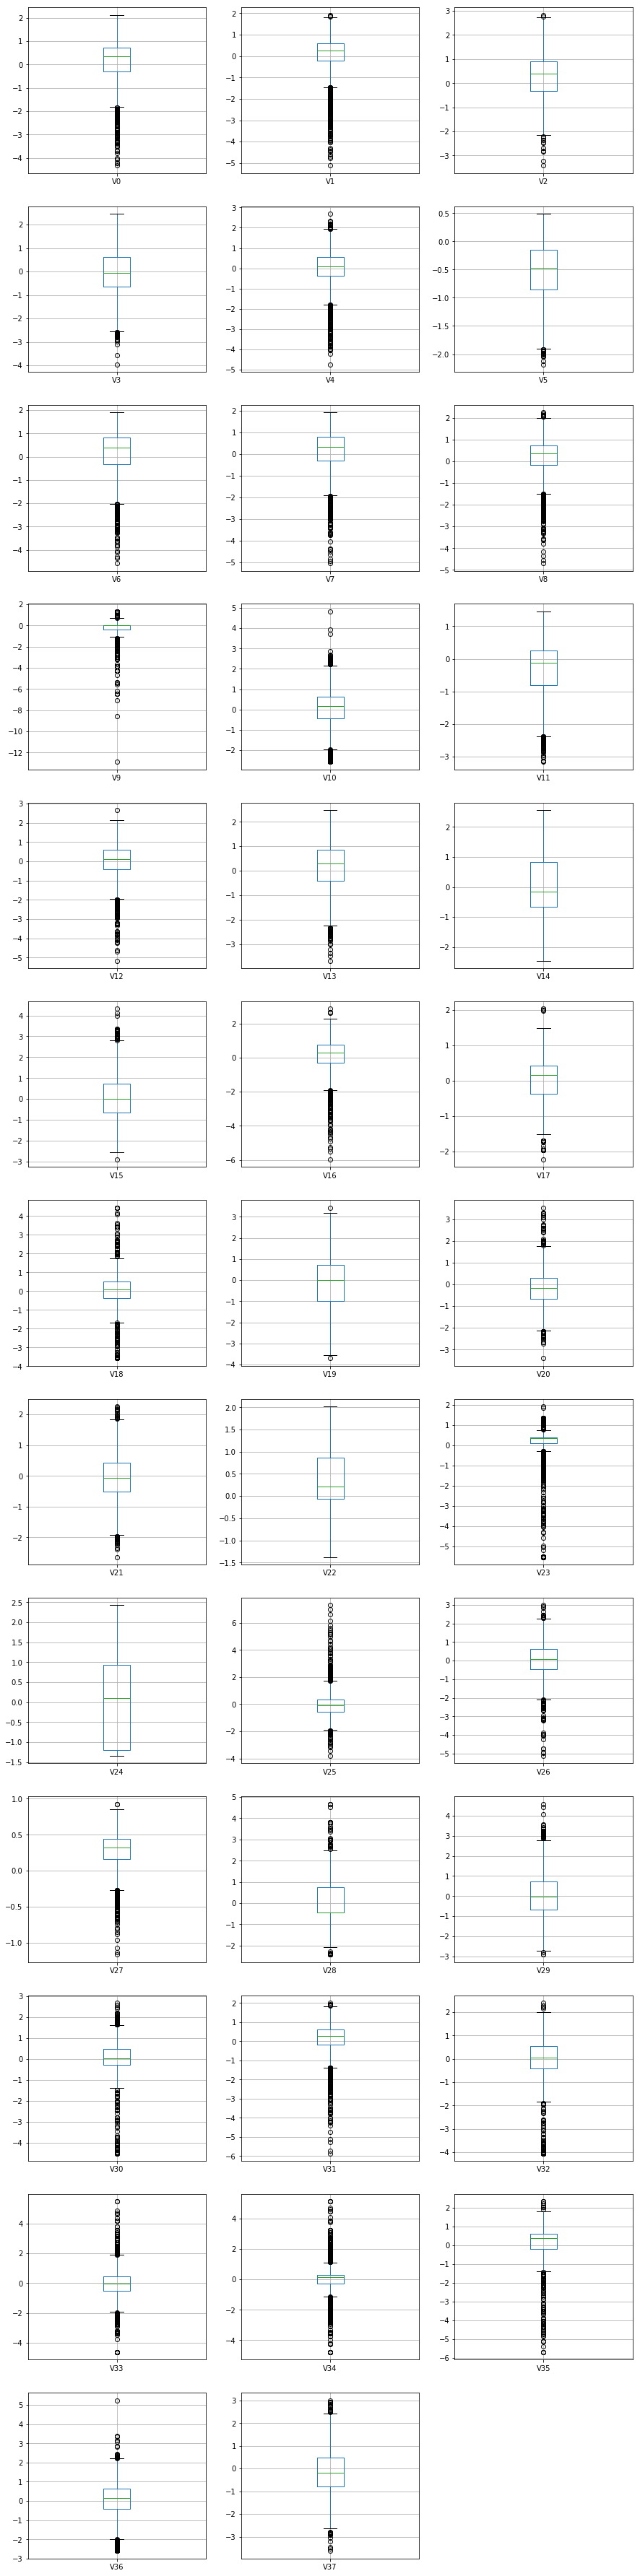

In [20]:
# 箱型图Interquartile Range(IQR), whis=1.5
# 单变量或双变量时可用箱型图， 多元变量时最好用多特征判断
cols = train_data.columns.tolist()[:-1]
fig = plt.figure(figsize = (3*5, 13*5))
i = 1
for col in cols:
    ax = plt.subplot(13, 3, i)
    train_data.boxplot(col, ax=ax)
    i += 1

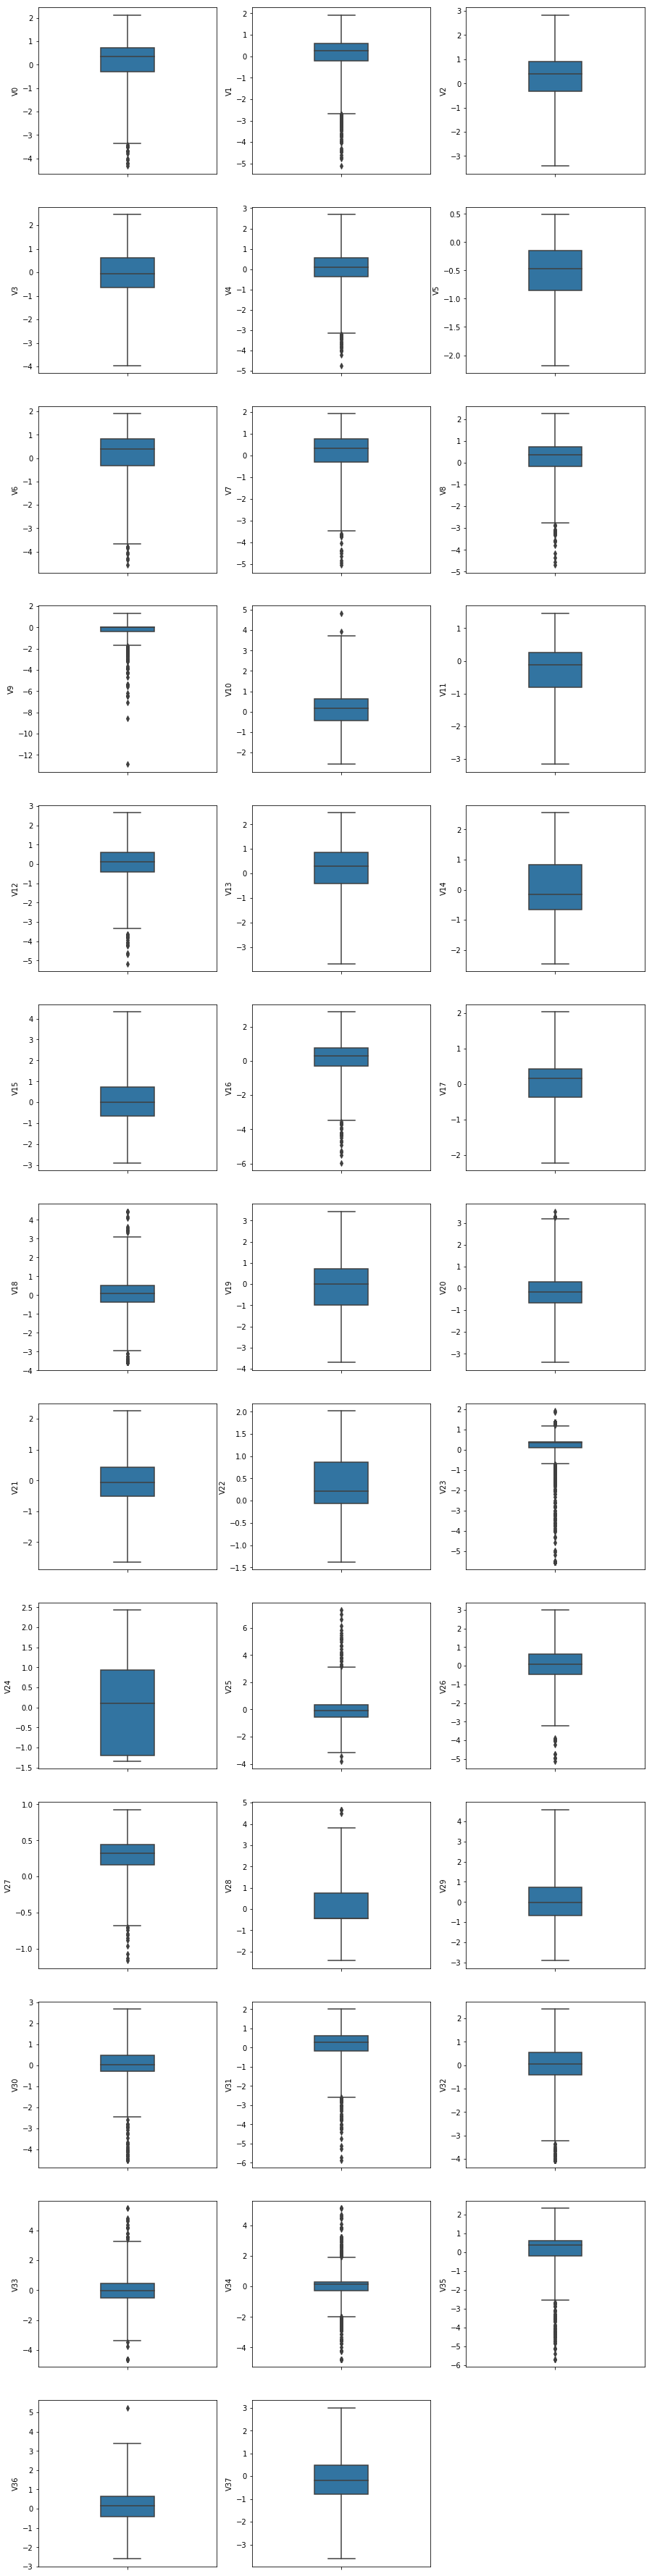

In [27]:
# 箱型图Interquartile Range(IQR), whis=3
cols = train_data.columns.tolist()[:-1]
fig = plt.figure(figsize = (3*5, 13*5))
i = 1
for col in cols:
    ax = plt.subplot(13, 3, i)
    sns.boxplot(y=col, data=train_data, ax=ax, whis=3, width=0.3)
    i += 1

In [5]:
X = train_data.drop("target", axis=1)
y = train_data.target

In [7]:
X.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

In [8]:
X

,V0,V1,V2,V3,V4,V6,V7,V8,V10,V12,...,V27,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.566,0.016,-0.143,0.407,0.452,-1.812,-2.360,-0.436,-0.940,-0.073,...,0.168,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508
1,0.968,0.437,0.066,0.566,0.194,-1.566,-2.360,0.332,0.188,-0.134,...,0.338,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730
2,1.013,0.568,0.235,0.370,0.112,-1.367,-2.360,0.396,0.874,-0.072,...,0.326,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589
3,0.733,0.368,0.283,0.165,0.599,-1.200,-2.086,0.403,0.011,-0.014,...,0.277,0.015,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112
4,0.684,0.638,0.260,0.209,0.337,-1.073,-2.086,0.314,-0.251,0.199,...,0.332,0.183,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028
5,0.445,0.627,0.408,0.220,0.458,-1.009,-1.896,0.481,-0.511,0.294,...,0.356,0.454,0.674,0.358,0.618,-0.843,-0.290,0.364,-0.191,-0.883
6,0.889,0.416,0.640,0.356,0.224,-0.812,-1.823,0.729,-0.256,0.425,...,0.401,0.454,0.081,0.243,0.468,-0.843,-0.290,0.364,-0.155,-1.318
7,0.984,0.529,0.704,0.438,0.258,-0.682,-1.721,0.753,-0.067,0.272,...,0.409,0.139,-0.050,0.428,-0.119,-0.843,-0.290,0.364,0.100,-0.899
8,0.948,0.850,0.584,0.459,0.591,-0.591,-1.524,0.763,0.205,0.387,...,0.490,0.188,0.467,0.597,-0.057,-0.843,-0.290,0.364,0.053,-0.553
9,1.157,1.055,0.638,0.617,1.483,-0.612,-1.524,0.968,0.145,0.688,...,0.512,0.860,0.456,0.916,0.039,-0.843,-0.290,0.364,0.151,-1.157


In [9]:
pd.DataFrame(y)

,target
0,0.175
1,0.676
2,0.633
3,0.206
4,0.384
5,0.060
6,0.415
7,0.609
8,0.981
9,0.818


In [10]:
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

mse_scorer = make_scorer(mse, greater_is_better=False)

In [11]:
def find_outliers(model, X, y, sigma=3):
    # 查找离群值
    # 标准偏差预先已知的情况
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid) / std_resid
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print('R2 =', model.score(X, y))
    print('mse =', mse(y, y_pred))
    print('---------------------------------------')
    
    print('mean of residuals:', mean_resid)
    print('std of residuals:', std_resid)
    print('---------------------------------------')
    
    print(len(outliers), 'outliers: ')
    print(outliers.tolist())
    
    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    # loc[1]是DataFrame的行索引, loc[1,2]是行列索引
    # o表示小圆圈，ro表示红色小圆圈
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y, y - y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r', bins=50, ax=ax_133)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('z')
    
    plt.show()
    
    return outliers

R2 = 0.8853726563655815
mse = 0.11094244665696637
---------------------------------------
mean of residuals: -4.982164265630896e-17
std of residuals: 0.3331379217948056
---------------------------------------
33 outliers: 
[321, 348, 376, 777, 884, 1145, 1164, 1310, 1523, 1537, 1704, 1874, 1879, 1905, 1979, 2002, 2159, 2160, 2264, 2279, 2528, 2620, 2645, 2647, 2667, 2668, 2669, 2696, 2767, 2769, 2807, 2842, 2863]


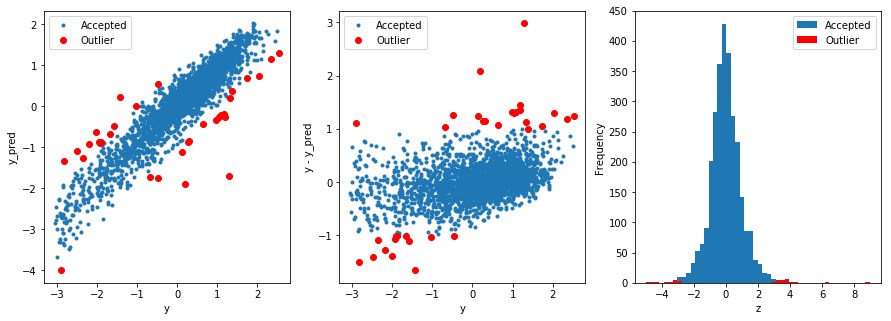

In [12]:
from sklearn.linear_model import Ridge

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=100)

outliers = find_outliers(Ridge(), X, y)

X_outliers = X.loc[outliers]
y_outliers = y.loc[outliers]
X_t = X.drop(outliers)
y_t = y.drop(outliers)

In [13]:
y.index

RangeIndex(start=0, stop=2888, step=1)

In [40]:
test_params1 = {'base_estimator__max_depth': range(10, 15, 1)}
gsearch1 = GridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),
                        learning_rate=0.5, loss='square', n_estimators=100,random_state=1), scoring='neg_mean_squared_error',
                        param_grid=test_params1, iid=False, cv=5, return_train_score=True)
gsearch1.fit(X_t, y_t)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_
# best max_depth = 13
# score = 0.11974124337542405

({'mean_fit_time': array([3.0327734 , 3.20718331, 3.34719143, 3.45299749, 3.53680229]),
  'std_fit_time': array([0.01015149, 0.01013962, 0.01191709, 0.01116133, 0.0095211 ]),
  'mean_score_time': array([0.01240072, 0.01360087, 0.01380081, 0.01460085, 0.01400089]),
  'std_score_time': array([0.00049   , 0.00048992, 0.00039992, 0.00048986, 0.00063256]),
  'param_base_estimator__max_depth': masked_array(data=[10, 11, 12, 13, 14],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'base_estimator__max_depth': 10},
   {'base_estimator__max_depth': 11},
   {'base_estimator__max_depth': 12},
   {'base_estimator__max_depth': 13},
   {'base_estimator__max_depth': 14}],
  'split0_test_score': array([-0.10147743, -0.10359139, -0.10049173, -0.0995506 , -0.10080521]),
  'split1_test_score': array([-0.14878618, -0.14653284, -0.147079  , -0.14837137, -0.14783281]),
  'split2_test_score': array([-0.10389244, -0.10234054, -0.1002

In [51]:
test_params2 = {'base_estimator__min_samples_split': range(21, 25, 1),
                'base_estimator__min_samples_leaf': range(5, 10, 1)}
gsearch1 = GridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13),
                        learning_rate=0.5, loss='square', n_estimators=100,random_state=1), scoring='neg_mean_squared_error', 
                        param_grid=test_params2, iid=False, cv=5, return_train_score=True)
gsearch1.fit(X_t, y_t)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_
# best min_samples_split = 23, best min_samples_leaf = 6
# score = 0.11790618343512475

({'mean_fit_time': array([2.8415626 , 2.83376203, 2.80696049, 2.79055958, 2.80776072,
         2.7973599 , 2.78375926, 2.75675769, 2.7725585 , 2.77095857,
         2.75315742, 2.74175677, 2.77215853, 2.77155852, 2.75835772,
         2.70535469, 2.79195957, 2.74795718, 2.72075567, 2.71895556]),
  'std_fit_time': array([0.00407946, 0.01209375, 0.00598025, 0.0056075 , 0.01272248,
         0.01090751, 0.01459673, 0.01870508, 0.0081146 , 0.00815895,
         0.0064192 , 0.01402363, 0.01721737, 0.05327446, 0.06821047,
         0.01545916, 0.02200494, 0.01599343, 0.01438976, 0.017222  ]),
  'mean_score_time': array([0.0114006 , 0.01100073, 0.01080065, 0.0108007 , 0.0108006 ,
         0.01100063, 0.01120067, 0.01120057, 0.01100068, 0.01100068,
         0.01180067, 0.01060052, 0.01140065, 0.01200066, 0.01240072,
         0.0108007 , 0.01180072, 0.01100044, 0.01120057, 0.01080065]),
  'std_score_time': array([4.90057117e-04, 6.32560492e-04, 4.00090228e-04, 3.99994861e-04,
         4.00066376e-04

In [58]:
test_params3 = {'learning_rate': [0.9, 0.95, 1.0]}
gsearch1 = GridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13,min_samples_split=23,
                                                                                         min_samples_leaf=6),
                        loss='square', n_estimators=100, random_state=1),  scoring='neg_mean_squared_error',  
                        param_grid=test_params3, iid=False, cv=5, return_train_score=True)
gsearch1.fit(X_t, y_t)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_
# best learning_rate = 1.0
# score = 0.11523667733589515

({'mean_fit_time': array([2.53214483, 2.49474263, 2.44794006]),
  'std_fit_time': array([0.00819804, 0.01467865, 0.01571583]),
  'mean_score_time': array([0.01100068, 0.01120071, 0.01080046]),
  'std_score_time': array([0.00063249, 0.00040004, 0.00039999]),
  'param_learning_rate': masked_array(data=[0.9, 0.95, 1.0],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.9},
   {'learning_rate': 0.95},
   {'learning_rate': 1.0}],
  'split0_test_score': array([-0.09459834, -0.09590386, -0.09369585]),
  'split1_test_score': array([-0.14617366, -0.14802989, -0.14455511]),
  'split2_test_score': array([-0.09968801, -0.09889716, -0.09877157]),
  'split3_test_score': array([-0.12531214, -0.12549419, -0.12325586]),
  'split4_test_score': array([-0.11838416, -0.11827632, -0.11590499]),
  'mean_test_score': array([-0.11683126, -0.11732028, -0.11523668]),
  'std_test_score': array([0.01856614, 0.01902042, 0.01821775]),
  

In [62]:
test_params4 = {'n_estimators': range(400, 801, 100)}
gsearch1 = GridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13,min_samples_split=23,
                                                                                         min_samples_leaf=6),
                        loss='square', learning_rate=1.0, random_state=1),  scoring='neg_mean_squared_error',
                        param_grid=test_params4, iid=False, cv=5, return_train_score=True)
gsearch1.fit(X_t, y_t)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 9.42413907, 11.75807252, 14.07920518, 16.39073744, 18.7752738 ]),
  'std_fit_time': array([0.05942595, 0.0900243 , 0.10032441, 0.11415977, 0.13908257]),
  'mean_score_time': array([0.04480247, 0.05620317, 0.06880403, 0.07880468, 0.09220529]),
  'std_score_time': array([0.00039997, 0.00040004, 0.00039995, 0.00172052, 0.0013268 ]),
  'param_n_estimators': masked_array(data=[400, 500, 600, 700, 800],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 400},
   {'n_estimators': 500},
   {'n_estimators': 600},
   {'n_estimators': 700},
   {'n_estimators': 800}],
  'split0_test_score': array([-0.0919689 , -0.0917988 , -0.09117306, -0.09144977, -0.0915743 ]),
  'split1_test_score': array([-0.14189083, -0.14102823, -0.14151819, -0.14124945, -0.14136026]),
  'split2_test_score': array([-0.09672693, -0.09580176, -0.09601645, -0.09561236, -0.09568736]),
  'split3_test_score': array(

In [63]:
gbm1 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13, min_samples_split=23, min_samples_leaf=6),  
                         loss='square', learning_rate=1.0, n_estimators=700, random_state=1)

In [65]:
gbm1.fit(X_t, y_t)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=23, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='square', n_estimators=700,
         random_state=1)

In [66]:
mean_squared_error(gbm1.predict(X_t), y_t)

0.014517761888356026

In [67]:
test_data

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104
2,-0.166,-0.062,-0.311,0.046,-0.055,0.063,0.485,0.493,-0.227,0.904,...,-0.458,-0.398,0.101,0.199,0.634,0.017,-0.234,0.008,0.373,0.569
3,0.102,0.294,-0.259,0.051,-0.183,0.148,0.474,0.504,0.010,0.904,...,-0.456,-0.398,1.007,0.137,1.042,-0.040,-0.290,0.008,-0.666,0.391
4,0.300,0.428,0.208,0.051,-0.033,0.116,0.408,0.497,0.155,0.904,...,-0.458,-0.776,0.291,0.370,0.181,-0.040,-0.290,0.008,-0.140,-0.497
5,0.050,0.340,0.108,0.051,-0.348,0.074,0.516,0.491,0.238,0.904,...,-0.450,-0.897,0.536,0.447,0.370,-0.040,-0.290,0.008,-0.228,0.169
6,-0.223,0.175,-0.390,0.051,0.006,0.134,0.497,0.548,-0.099,0.904,...,-0.452,-0.937,0.249,0.432,0.494,-0.040,-0.290,0.008,0.104,1.077
7,-0.126,0.152,0.227,0.021,-0.619,-0.069,0.520,0.548,0.060,0.904,...,-0.452,-0.950,1.256,0.281,0.555,-0.040,-0.290,0.008,-0.700,-0.498
8,-0.203,-0.014,0.010,-0.034,-0.322,0.105,0.453,0.518,-0.032,0.473,...,-0.450,-0.950,0.078,0.222,0.245,-0.040,-0.290,0.008,-0.236,-0.149
9,-0.181,0.797,0.470,-0.107,-0.477,0.184,0.588,0.528,0.319,0.904,...,-0.446,-1.092,-0.131,0.466,0.430,-0.040,-0.290,-0.289,-0.431,-0.271


In [68]:
test_data.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

In [70]:
ans = gbm1.predict(test_data)
pd.DataFrame(ans).to_csv("./AdaBoostRegressorNoOutliers3.txt", index=False, header=False)